# Equity Pair Strategy

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import math
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import median_absolute_error

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import median_absolute_error
import bs4 as bs
import requests
import datetime

import backtesting

/home/fanconic/anaconda3/envs/myenv/lib/python3.8/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

## Scrape and Download all the S&P 500 Companies

In [2]:
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]

In [3]:
start = datetime.datetime(2011,1,1)
end = datetime.datetime(2021,12,31)
data = yf.download(tickers, start=start, end=end)

[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


## Preprocess Data

In [4]:
data = data.drop('BRK.B', axis=1, level=1)
data = data.drop('BF.B', axis=1, level=1)
data = data.drop('GOOG', axis=1, level=1)

In [5]:
close_data = data['Adj Close']
open_data = data['Open']

to_drop = close_data.columns[close_data.isna().sum() > 100].values.tolist()

close_data = close_data.drop(to_drop, axis= 1)
close_data = close_data.dropna()

open_data = open_data.drop(to_drop, axis= 1)
open_data = open_data.dropna()

In [6]:
# Divide into training time and testing time
train_start = start
train_end = datetime.datetime(2016,12,31)

val_start = datetime.datetime(2017,1,1)
val_end = datetime.datetime(2018,12,31)

test_start = datetime.datetime(2019,1,1)
test_end = end

train_mask = (close_data.index > train_start) & (close_data.index <= train_end)
val_mask = (close_data.index > val_start) & (close_data.index <= val_end)
test_mask = (close_data.index > test_start) & (close_data.index <= test_end)

In [23]:
# Take the log, such that we have all the numers in the reals
log_close_data = close_data

In [24]:
# Normalize data with min max normalization
norm_data = (close_data - close_data.min()) / (close_data.max() - close_data.min())
norm_log_data = (log_close_data - log_close_data.min()) / (log_close_data.max() - log_close_data.min())

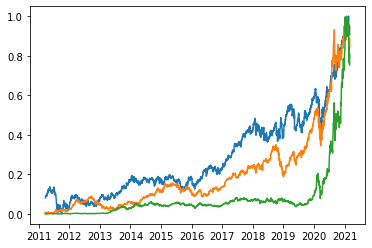

In [25]:
plt.plot(norm_data[['A', 'AAPL', 'TSLA']])

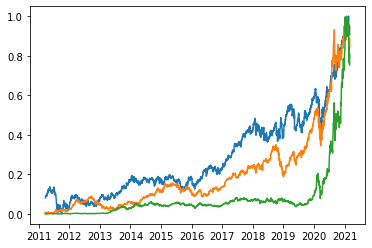

In [26]:
plt.plot(norm_log_data[['A', 'AAPL', 'TSLA']])

## Search for most similar pairs in the L2 distance metric

In [27]:
from sklearn.metrics.pairwise import euclidean_distances
pairwise_dist = euclidean_distances(norm_log_data.loc[train_mask].T, norm_log_data.loc[train_mask].T)

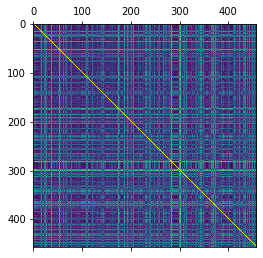

In [28]:
# Similarity Matrix Adjustment, because we don't want the most similar stock to be the one itself
similarity_matrix = pairwise_dist+pairwise_dist.max()*np.eye(pairwise_dist.shape[0])
plt.matshow(similarity_matrix - np.diag(similarity_matrix))

In [29]:
most_similar = similarity_matrix.argmin(axis=1)

In [30]:
# Sorting for most similar:
pairs = pd.DataFrame()
pairs['ticker1'] = norm_log_data.columns
pairs['ticker2'] = norm_log_data.columns[most_similar]
pairs['distance'] = similarity_matrix[np.arange(similarity_matrix.shape[0]),most_similar]
pairs = pairs.sort_values('distance').reset_index()
pairs = pairs.iloc[::2, :]

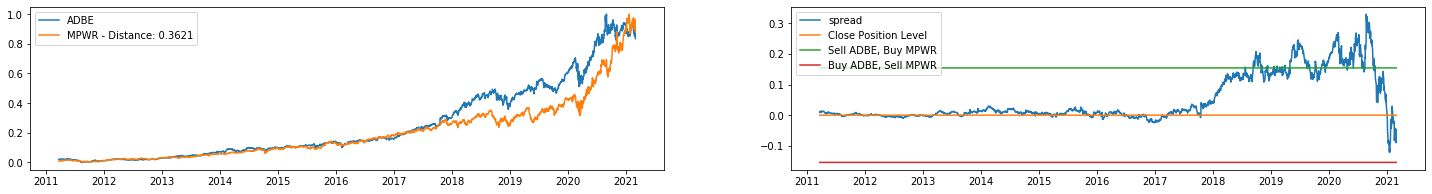

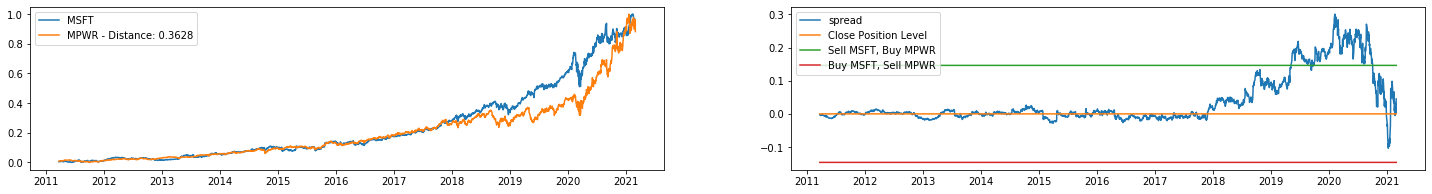

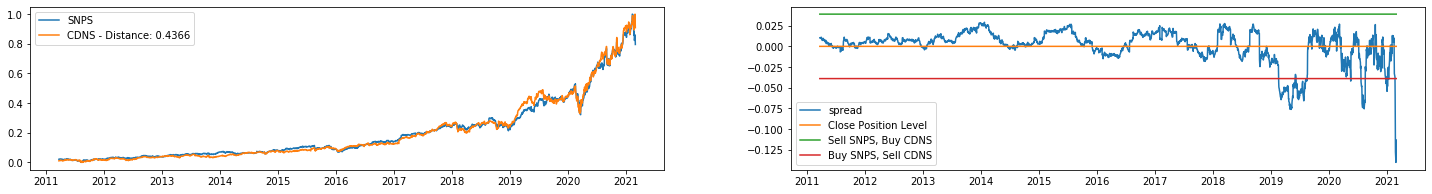

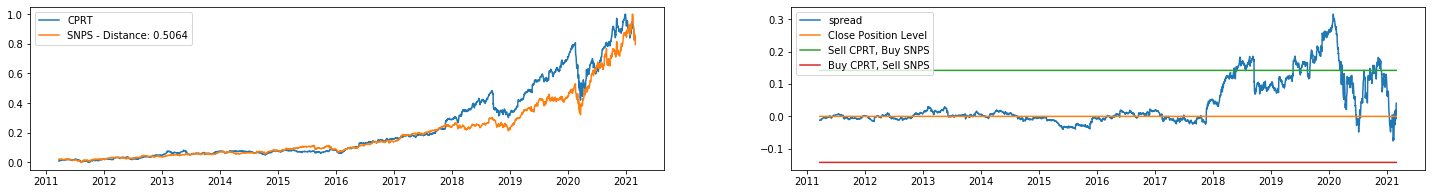

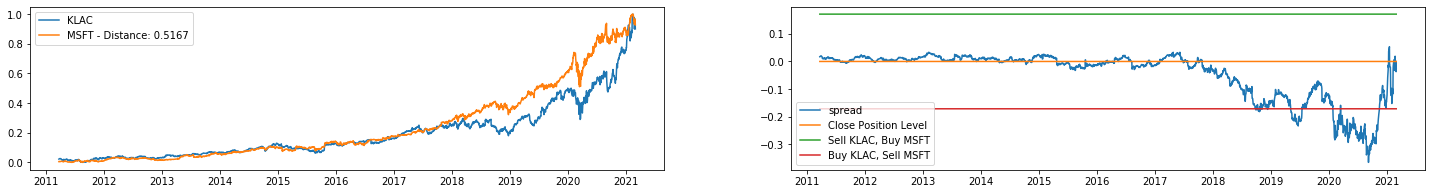

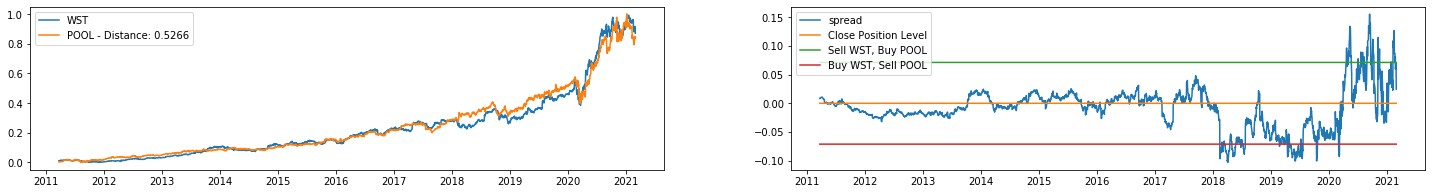

In [31]:
for i, stonks in pairs.iterrows():
    ticker1 = stonks['ticker1']
    ticker2 = stonks['ticker2']
    
    plt.figure(figsize=(25,3))
    
    # Show the two stocks
    plt.subplot(1, 2, 1)
    plt.plot(norm_log_data[ticker1], label = ticker1)
    plt.plot(norm_log_data[ticker2], label = ticker2 + " - Distance: {:.4f}".format(stonks['distance']))
    plt.legend()
    
    
    # Show their spread, including the standard deviation
    plt.subplot(1, 2, 2)
    spread = norm_log_data[ticker1] - norm_log_data[ticker2]
    spread_std = spread.std()
    plt.plot(spread, label = 'spread')
    plt.plot(norm_log_data.index, np.zeros(spread.shape[0]), label = 'Close Position Level')
    plt.plot(norm_log_data.index, np.zeros(spread.shape[0])+2*spread_std, label = 'Sell {}, Buy {}'.format(ticker1, ticker2))
    plt.plot(norm_log_data.index, np.zeros(spread.shape[0])-2*spread_std, label = 'Buy {}, Sell {}'.format(ticker1, ticker2))
    plt.legend()
    plt.show()
    
    if i == 10:
        break

## Backtesting

In [33]:
def preprocess(X, log=False):
    """
    Compute the log of the data and then normailze it to max and min
    Args:
        X (pd.DataFrame): Data
        log (default False): flag, natural logarithm should be applied before
    Returns the preprocessed data
    """
    if log:
        X = np.log(X)
    norm_data = (X - X.min()) / (X.max() - X.min())
    return norm_data


def spreadStd(ticker1, ticker2):
    """
    Compute the spread of two stock, as well as their volatility
    Args:
        ticker1 (pd.DataFrame): first stock
        ticker2 (pd.DataFrame): first stock
    Returns the difference of ticker1 to ticker2 as well as its standard deviation
    """
    spread = ticker1 - ticker2
    spread_std = spread.std()
    spread_std = np.ones(spread.shape[0]) * spread_std
    
    upper = np.ones(spread.shape[0]) * 2*spread_std
    lower = np.ones(spread.shape[0]) * (-2*spread_std)
    return spread, spread_std, upper, lower


def stdCrossOver(spread, std, crossOverFactor):
    """
    Compute buy, sell or hold signal if the spread becomes higher or lower than its historic standard deviation
    Args:
        spread (flaot): spreads
        std (float): historic standard deviation
        crossOVerFactor (float): multiple of standard deviations as safety line
    Returns
        -1: lower than lower bound
        0 : in region
        +1: upper than upper bound
    """
    if spread > crossOverFactor*std:
        return 1
    elif spread < -crossOverFactor*std:
        return -1
    else:
        return 0

In [34]:
from backtesting import Strategy

class PairDistance(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    std_cross = 2
    
    def init(self):
        
        #take the log and normalize the two tickers
        # Ticker1 is hidden in the Open data, and Ticker2 is hidden in the Close data
        # This is because of the nature of the backtesting framework
        self.ticker1 = self.I(preprocess, self.data.Ticker1_Close, False)
        self.ticker2 = self.I(preprocess, self.data.Ticker2_Close, False)
        
        # Calculate Spread and volatility
        self.spread, self.std, _, _ = self.I(spreadStd, self.ticker1, self.ticker2)
    
    def next(self):
        signal = stdCrossOver(self.spread, self.std, self.std_cross)
        
        if signal == 1:
            self.position.close()
            self.sell()
            
        elif signal == -1:
            self.position.close()
            self.buy()
            
        else:
            pass

In [35]:
pairs[:10]

,index,ticker1,ticker2,distance
0,8,ADBE,MPWR,0.362124
2,286,MSFT,MPWR,0.362796
4,371,SNPS,CDNS,0.436621
6,101,CPRT,SNPS,0.506396
8,233,KLAC,MSFT,0.516726
10,445,WST,POOL,0.526620
12,326,PGR,POOL,0.572205
14,105,CTAS,ROL,0.585080
16,56,BIO,SNPS,0.602644
18,405,TXN,MTD,0.607906


In [36]:
# Prepare Data
ticker1 = 'ADBE'
ticker2 = 'MPWR'
test_pair = pd.DataFrame()
test_pair['Open'] = open_data.loc[val_mask][ticker1] / open_data.loc[val_mask][ticker2]
test_pair['Close'] =  close_data.loc[val_mask][ticker1] / close_data.loc[val_mask][ticker2]
test_pair['Ticker1_Close'] = close_data.loc[val_mask][ticker1]
test_pair['Ticker2_Close'] = close_data.loc[val_mask][ticker2]
test_pair['High'] = np.zeros(test_pair.shape[0])
test_pair['Low'] = np.zeros(test_pair.shape[0])

In [37]:
from backtesting import Backtest

bt = Backtest(test_pair, PairDistance, cash=5_000, commission=.002)
stats = bt.run()
stats

Start                     2017-01-03 00:00:00
End                       2018-12-31 00:00:00
Duration                    727 days 00:00:00
Exposure Time [%]                      37.251
Equity Final [$]                      4625.07
Equity Peak [$]                       5515.97
Return [%]                           -7.49867
Buy & Hold Return [%]                 54.4817
Return (Ann.) [%]                    -3.83732
Volatility (Ann.) [%]                 17.9042
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -29.7376
Avg. Drawdown [%]                    -6.21142
Max. Drawdown Duration      117 days 00:00:00
Avg. Drawdown Duration       30 days 00:00:00
# Trades                                   39
Win Rate [%]                          51.2821
Best Trade [%]                        3.23168
Worst Trade [%]                      -4.36374
Avg. Trade [%]                    

In [38]:
bt.plot()

## Testing the Algorithm

In [39]:
test_pair = pd.DataFrame()
test_pair['Open'] = open_data.loc[test_mask][ticker1] / open_data.loc[test_mask][ticker2]
test_pair['Close'] =  close_data.loc[test_mask][ticker1] / close_data.loc[test_mask][ticker2]
test_pair['Ticker1_Close'] = close_data.loc[test_mask][ticker1]
test_pair['Ticker2_Close'] = close_data.loc[test_mask][ticker2]
test_pair['High'] = np.zeros(test_pair.shape[0])
test_pair['Low'] = np.zeros(test_pair.shape[0])
bt = Backtest(test_pair, PairDistance, cash=5_000, commission=.002)
stats = bt.run()
display(stats)
bt.plot()

Start                     2019-01-02 00:00:00
End                       2021-03-03 00:00:00
Duration                    791 days 00:00:00
Exposure Time [%]                          50
Equity Final [$]                      6250.34
Equity Peak [$]                       6517.81
Return [%]                            25.0069
Buy & Hold Return [%]                -36.4539
Return (Ann.) [%]                     10.8508
Volatility (Ann.) [%]                 29.5756
Sharpe Ratio                         0.366883
Sortino Ratio                        0.619324
Calmar Ratio                         0.461989
Max. Drawdown [%]                    -23.4871
Avg. Drawdown [%]                     -6.3109
Max. Drawdown Duration      147 days 00:00:00
Avg. Drawdown Duration       29 days 00:00:00
# Trades                                   90
Win Rate [%]                          48.8889
Best Trade [%]                        22.3754
Worst Trade [%]                      -5.36861
Avg. Trade [%]                    